* ## Neighborhood Sampling
* ## Cluster-GCN
* ## Backends

In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507268 sha256=29308ecbd3f1caa2c97c0f5316e9a6bc7892049068ff39a7d7ad7cb0ef4d3488
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092566 sha256=558ba34fdb5181dcf0ea6e882c35fb75ab1d01f136f46bff8478556fca71e866
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built 

In [4]:
#Neighboorhood Sampling
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid("./tmp", "Cora")

Processing...
Done!


In [11]:
from torch_geometric.nn import SAGEConv

In [13]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="minibatch"):
        if mode == "minibatch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
#neighborhood sampling using networkx and deepsnap
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)  #4, edges
    edge_index = edge_index.permute(1, 0)   #edges, 4
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:    #orig_edges = [(node1, node2), (node3, node4)]
        relabeled_edges = []
        for edge in orig_edges:     #edge = (node1, node2)
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor
    # sampling ratios for each layer. This function returns relabeled node feature,
    # edge indices and node_label_index

    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)

    # Reverse the lists
    nodes_list.reverse()  #from farthest to nearest neighbors
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    node_feature = graph.node_feature[node_index] # remeber objects are tensors, node_index is an idx tensor
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index


In [15]:
#Training and testing functions
def train(train_graphs, val_graphs, args, model, optimizer, mode="minibatch"):
  best_val = 0
  best_model = None
  accs = []
  graph_train = train_graphs[0] #dataset object
  graph_train.to(args['device'])
  for epoch in range(args['epochs']):
    model.train()
    optimizer.zero_grad()
    if mode == "minibatch":
      node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train,
                                                                       args['num_layers'], args['ratios'])
      node_feature, node_label_index = node_feature.to(args['device']), node_label_index.to(args['device'])
      for i in range(len(edge_indices)):
        edge_indices[i] = edge_indices[i].to(args['device'])
      pred = model((edge_indices, node_feature))  #A tuple would be a better choice
      pred = pred[node_label_index]
      label = graph_train.node_label[node_label_index]
    elif mode =="community":
      graph = random.choice(train_graphs)  #training minibatches are graph cluster (Cluster-GCN)
      graph = graph.to(args['device'])
      pred = model(graph, mode='all')  #any other aside 'minibatch' will use model else case
      pred = pred[graph.node_label_index]
      label = graph.node_label[graph.node_label_index]
    else:           #a case of random sampling
      pred = model(graph_train, mode='all')
      label = graph_train.node_label
      pred = pred[graph_train.node_label_index]
    loss = F.nll_loss(pred, label)
    loss.backward()
    optimizer.step()

    train_acc, val_acc, test_acc = test(val_graphs, model)
    accs.append((train_acc, val_acc, test_acc))
    if val_acc > best_val:
      best_val = val_acc
      best_model = copy.deepcopy(model)
    print(f'''
    Epoch:{epoch:2d},
    Loss:{loss:.4f},
    Train:{100*train_acc:.2f},
    Validation:{100*val_acc:.2f},
    Test:{100*test_acc:.2f}
    ''')
  return best_model, accs

@torch.no_grad()
def test(graphs, model):
  model.eval()
  accs = []
  for graph in graphs:
    graph = graph.to(args['device'])
    pred = model(graph, mode='all')
    label = graph.node_label
    pred = pred[graph.node_label_index].max(1)[1]
    acc = pred.eq(label).sum().item()
    acc /= len(label)
    accs.append(acc)
  return accs

In [9]:
args = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dropout": 0.5,
    "num_layers": 2,
    "hidden_size": 64,
    "lr": 0.005,
    "epochs": 50,
    "ratios": (0.8, 0.8, 1),
}


In [16]:
'''Full Batch Training'''
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                     verbose=True, fixed_split=True)
model = GNN(graphs_train[0].num_node_features, args['hidden_size'],
            graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graphs_train[0], graphs_val[0], graphs_test[0]]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer,
                                 mode='all')
train_accs, val_accs, test_acc = test(graphs, all_best_model)
print(f'''
      Train:{100*train_accs:.2f}%,
      Validation:{100*val_accs:.2f}%,
      Test:{100*test_acc:.2f}%
''')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.

    Epoch: 0,
    Loss:2.0022,
    Train:57.14,
    Validation:16.00,
    Test:14.20
    

    Epoch: 1,
    Loss:1.1437,
    Train:97.14,
    Validation:49.40,
    Test:52.00
    

    Epoch: 2,
    Loss:0.6379,
    Train:99.29,
    Validation:60.00,
    Test:61.70
    

    Epoch: 3,
    Loss:0.3475,
    Train:100.00,
    Validation:63.40,
    Test:64.60
    

    Epoch: 4,
    Loss:0.1696,
    Train:100.00,
    Validation:66.20,
    Test:67.50
    

    Epoch: 5,
    Loss:0.0779,
    Train:100.00,
    Validation:68.80,
    Test:70.10
    

    Epoch: 6,
    Loss:0.0431,
    Train:100.00,
    Validation:69.60,
    Test:71.30
    

    Epoch: 7,
    Loss:0.0301,
    Train:100.00,
    Validation:70.00,
    Test:72.20
    

    Epoch: 8,
    Loss:0.0207,
    Train:100.00,
    Validation:70.60,
    Test:72.70
    

    Epoch: 9,
    Loss:0.0083,
    Train:100.00,
    Validation:71.60,
    

In [17]:
'''Mini-Batch Training (Neighborhood Sampling)'''
#using a .8 sampling ratio
args['ratios'] = (0.8, 0.8, 1)
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=True, fixed_split=True)
model = GNN(graphs_train[0].num_node_features, args['hidden_size'],
            graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graphs_train[0], graphs_val[0], graphs_test[0]]

all_batch_model_1, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test(graphs, all_batch_model_1)
print(f'''
      Train:{100*train_accs:.2f}%,
      Validation:{100*val_accs:.2f}%,
      Test:{100*test_acc:.2f}%
''')



Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 1309 nodes, 1960 edges, 140 labeled nodes

    Epoch: 0,
    Loss:1.9848,
    Train:27.14,
    Validation:14.00,
    Test:15.60
    
Sampled 1283 nodes, 1950 edges, 140 labeled nodes

    Epoch: 1,
    Loss:1.6645,
    Train:55.00,
    Validation:27.00,
    Test:26.60
    
Sampled 1305 nodes, 1961 edges, 140 labeled nodes

    Epoch: 2,
    Loss:1.3377,
    Train:77.14,
    Validation:34.80,
    Test:36.60
    
Sampled 1333 nodes, 2046 edges, 140 labeled nodes

    Epoch: 3,
    Loss:1.1350,
    Train:85.00,
    Validation:36.60,
    Test:39.70
    
Sampled 1334 nodes, 2042 edges, 140 labeled nodes

    Epoch: 4,
    Loss:0.8990,
    Train:91.43,
    Validation:40.80,
    Test:44.50
    
Sampled 1302 nodes, 1934 edges, 140 labeled nodes

    Epoch: 5,
    Loss:0.6767,
    Train:95.00,
    Validation:46.00,
    Test:50.50
    
Sampled 1309 nodes, 1980 edges, 140 labeled nodes

    

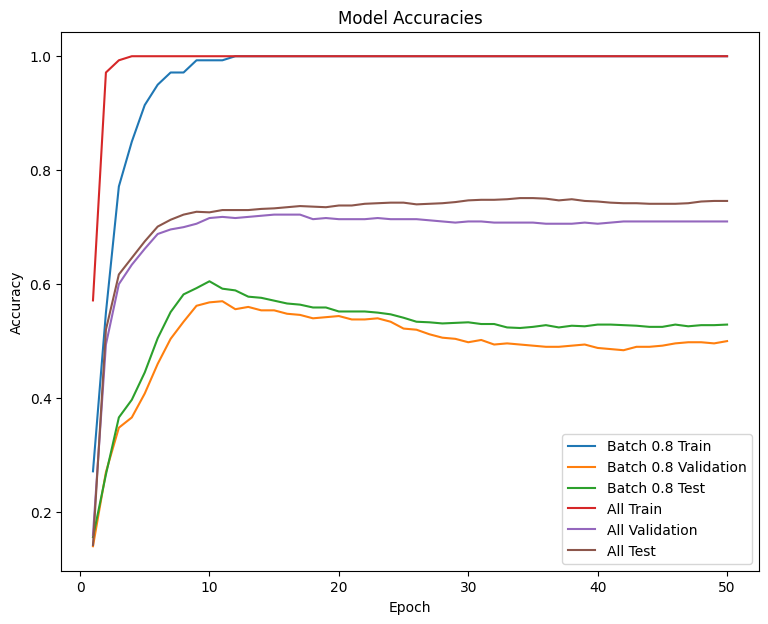

In [18]:
all_results = np.array(all_accs)
batch_results_1 = np.array(batch_accs_1)


x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results_1[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results_1[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results_1[:, 2], label="Batch 0.8 Test")
plt.plot(x, all_results[:, 0], label="All Train")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Cluster Sampling (Cluster-GCN)

we'll utilize 3 different community partitioning algorithms

* Kernighan-Lin algorithm(bisection)
* Clauset-Newman-Moore greedy modularity
* Louvain Algorithm

In [44]:
import community.community_louvain as louvain

args = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dropout": 0.5,
    "num_layers": 2,
    "hidden_size": 64,
    "lr": 0.005,
    "epochs": 150,
}

In [37]:
#discard clusters with less than 10 nodes inorder to stabilize training
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs


In [45]:
#Louvain process
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=True, fixed_split=True)
graphs = preprocess(graphs_train[0].G, graphs_train[0].node_label_index, method="louvain")
print(f"partiton the graph into {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
  avg_num_nodes += graph.num_nodes
  avg_num_edges += graph.num_edges
avg_num_nodes /= len(graphs)
avg_num_edges /= len(graphs)
print(f"Each community has {int(avg_num_nodes)} average nodes and {int(avg_num_edges)} average edges")

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
partiton the graph into 76 communities
Each community has 21 average nodes and 32 average edges


In [46]:
model = GNN(graphs_train[0].num_node_features, args['hidden_size'], \
    graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, \
    [graphs_train[0], graphs_val[0], graphs_test[0]], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graphs_train[0], graphs_val[0], graphs_test[0]], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')


    Epoch: 0,
    Loss:2.1909,
    Train:14.29,
    Validation:5.80,
    Test:6.40
    

    Epoch: 1,
    Loss:1.9642,
    Train:15.71,
    Validation:6.00,
    Test:6.50
    

    Epoch: 2,
    Loss:2.2464,
    Train:17.86,
    Validation:9.40,
    Test:9.40
    

    Epoch: 3,
    Loss:2.0184,
    Train:13.57,
    Validation:12.20,
    Test:12.40
    

    Epoch: 4,
    Loss:2.5223,
    Train:15.71,
    Validation:11.80,
    Test:12.90
    

    Epoch: 5,
    Loss:0.1757,
    Train:15.71,
    Validation:12.20,
    Test:12.90
    

    Epoch: 6,
    Loss:1.8704,
    Train:15.71,
    Validation:12.40,
    Test:13.00
    

    Epoch: 7,
    Loss:1.3514,
    Train:17.14,
    Validation:12.20,
    Test:13.00
    

    Epoch: 8,
    Loss:3.7737,
    Train:18.57,
    Validation:12.20,
    Test:13.10
    

    Epoch: 9,
    Loss:0.1308,
    Train:19.29,
    Validation:12.40,
    Test:13.30
    

    Epoch:10,
    Loss:2.7402,
    Train:19.29,
    Validation:12.60,
    Test:13.30
    

    

In [39]:
#bisection process
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=True, fixed_split=True)
graphs = preprocess(graphs_train[0].G, graphs_train[0].node_label_index, method="bisection")
print(f"partiton the graph into {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
  avg_num_nodes += graph.num_nodes
  avg_num_edges += graph.num_edges
avg_num_nodes /= len(graphs)
avg_num_edges /= len(graphs)
print(f"Each community has {int(avg_num_nodes)} average nodes and {int(avg_num_edges)} average edges")

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
partiton the graph into 2 communities
Each community has 1354 average nodes and 2384 average edges


In [40]:
model = GNN(graphs_train[0].num_node_features, args['hidden_size'], \
    graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, \
    [graphs_train[0], graphs_val[0], graphs_test[0]], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graphs_train[0], graphs_val[0], graphs_test[0]], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')


    Epoch: 0,
    Loss:1.9998,
    Train:35.00,
    Validation:22.80,
    Test:24.00
    

    Epoch: 1,
    Loss:1.9558,
    Train:65.71,
    Validation:34.00,
    Test:36.30
    

    Epoch: 2,
    Loss:0.8184,
    Train:95.71,
    Validation:51.00,
    Test:52.40
    

    Epoch: 3,
    Loss:0.4700,
    Train:100.00,
    Validation:59.00,
    Test:61.30
    

    Epoch: 4,
    Loss:0.7035,
    Train:100.00,
    Validation:65.20,
    Test:64.80
    

    Epoch: 5,
    Loss:0.5214,
    Train:100.00,
    Validation:67.20,
    Test:67.40
    

    Epoch: 6,
    Loss:0.1248,
    Train:100.00,
    Validation:68.00,
    Test:68.30
    

    Epoch: 7,
    Loss:0.1804,
    Train:100.00,
    Validation:68.60,
    Test:70.40
    

    Epoch: 8,
    Loss:0.0376,
    Train:100.00,
    Validation:68.60,
    Test:71.50
    

    Epoch: 9,
    Loss:0.0484,
    Train:100.00,
    Validation:69.40,
    Test:71.90
    

    Epoch:10,
    Loss:0.0563,
    Train:100.00,
    Validation:69.60,
    Test:72

In [41]:
#greedy process
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=True, fixed_split=True)
graphs = preprocess(graphs_train[0].G, graphs_train[0].node_label_index, method="greedy")
print(f"partiton the graph into {len(graphs)} communities")
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
  avg_num_nodes += graph.num_nodes
  avg_num_edges += graph.num_edges
avg_num_nodes /= len(graphs)
avg_num_edges /= len(graphs)
print(f"Each community has {int(avg_num_nodes)} average nodes and {int(avg_num_edges)} average edges")

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
partiton the graph into 20 communities
Each community has 121 average nodes and 222 average edges


In [42]:
model = GNN(graphs_train[0].num_node_features, args['hidden_size'], \
    graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, \
    [graphs_train[0], graphs_val[0], graphs_test[0]], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graphs_train[0], graphs_val[0], graphs_test[0]], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')


    Epoch: 0,
    Loss:2.0594,
    Train:14.29,
    Validation:14.80,
    Test:14.70
    

    Epoch: 1,
    Loss:1.9928,
    Train:14.29,
    Validation:16.20,
    Test:14.90
    

    Epoch: 2,
    Loss:2.3617,
    Train:15.71,
    Validation:16.00,
    Test:14.90
    

    Epoch: 3,
    Loss:2.4645,
    Train:17.86,
    Validation:15.80,
    Test:14.70
    

    Epoch: 4,
    Loss:2.6256,
    Train:22.14,
    Validation:15.40,
    Test:14.40
    

    Epoch: 5,
    Loss:1.8056,
    Train:27.14,
    Validation:14.20,
    Test:13.30
    

    Epoch: 6,
    Loss:0.0790,
    Train:30.00,
    Validation:13.80,
    Test:13.20
    

    Epoch: 7,
    Loss:2.2630,
    Train:30.71,
    Validation:11.60,
    Test:12.90
    

    Epoch: 8,
    Loss:1.7061,
    Train:30.71,
    Validation:11.00,
    Test:12.00
    

    Epoch: 9,
    Loss:0.0147,
    Train:35.00,
    Validation:12.40,
    Test:13.40
    

    Epoch:10,
    Loss:1.2415,
    Train:32.86,
    Validation:18.80,
    Test:21.30
    

In [43]:
#Full Batch Training
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

model = GNN(graphs_train[0].num_node_features, args['hidden_size'], \
    graphs_train[0].num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graphs_train[0], graphs_val[0], graphs_test[0]]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = \
    test([graphs_train[0], graphs_val[0], graphs_test[0]], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.

    Epoch: 0,
    Loss:2.0293,
    Train:77.86,
    Validation:29.20,
    Test:31.70
    

    Epoch: 1,
    Loss:1.1221,
    Train:96.43,
    Validation:47.40,
    Test:46.20
    

    Epoch: 2,
    Loss:0.6679,
    Train:100.00,
    Validation:55.80,
    Test:57.30
    

    Epoch: 3,
    Loss:0.3290,
    Train:100.00,
    Validation:62.60,
    Test:62.90
    

    Epoch: 4,
    Loss:0.1746,
    Train:100.00,
    Validation:67.00,
    Test:66.70
    

    Epoch: 5,
    Loss:0.0955,
    Train:100.00,
    Validation:69.20,
    Test:68.50
    

    Epoch: 6,
    Loss:0.0478,
    Train:100.00,
    Validation:69.60,
    Test:69.90
    

    Epoch: 7,
    Loss:0.0193,
    Train:100.00,
    Validation:70.40,
    Test:71.60
    

    Epoch: 8,
    Loss:0.0102,
    Train:100.00,
    Validation:70.60,
    Test:72.70
    

    Epoch: 9,
    Loss:0.0072,
    Train:100.00,
    Validation:71.20,
   

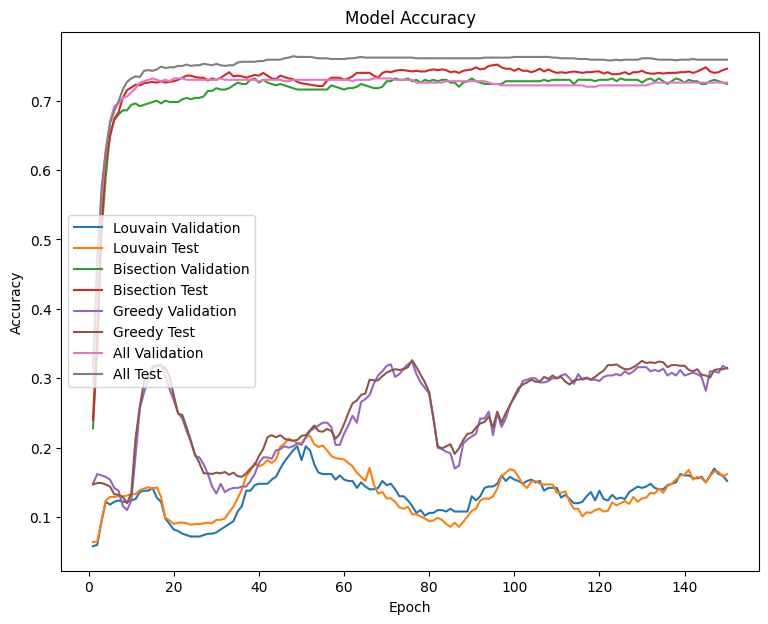

In [47]:
louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], label="Louvain Test")
plt.plot(x, bisection_results[:, 1], label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], label="Bisection Test")
plt.plot(x, greedy_results[:, 1], label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Switching Backends

* switching between Networkx and snapx backends

* changing to a tensor backend

In [ ]:
import snap
import snapx as sx

import networkx as nx

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

pyg_dataset = Planetoid("./tmp", "Cora")

In [ ]:
#change using `deepsnap.use` or the   `pyg_to_graphs` method
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=False, fixed_split=True)
print(graphs_train[0].G.__class__)  #networkx graph

In [ ]:
#change using deepsnap.use
deepsnap.use(sx)
graphs_train, graphs_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset,
                                                                   verbose=False, fixed_split=True)
print(graphs_train[0].G.__class__) #snapx graph

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=False, fixed_split=True, netlib=nx)
print(graphs_train[0].G.__class__) #networkx

In [ ]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=False, fixed_split=True, netlib=sx)
print(graphs_train[0].G.__class__) #snapx